In [ ]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import json
from tqdm import tqdm
import re
import time
import argparse

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

In [ ]:
!pip install mlflow --quiet

In [ ]:
import mlflow
import mlflow.pytorch
from mlflow.tracking import MlflowClient

In [ ]:
def setup_mlflow(experiment_name="handwritten-math-recognition"):
    """Set up MLflow experiment"""
    mlflow.set_experiment(experiment_name)
    return mlflow.start_run()

In [ ]:
def log_params(config):
    """Log model parameters to MLflow"""
    # Log model architecture parameters
    mlflow.log_param("embed_dim", config.embed_dim)
    mlflow.log_param("hidden_dim", config.hidden_dim)
    mlflow.log_param("num_layers", config.num_layers)
    mlflow.log_param("dropout", config.dropout)
    mlflow.log_param("max_seq_len", config.max_seq_len)
    
    # Log training parameters
    mlflow.log_param("batch_size", config.batch_size)
    mlflow.log_param("num_epochs", config.num_epochs)
    mlflow.log_param("learning_rate", config.learning_rate)
    mlflow.log_param("teacher_forcing_ratio", config.teacher_forcing_ratio)
    mlflow.log_param("teacher_forcing_decay", config.teacher_forcing_decay)
    mlflow.log_param("grad_clip", config.grad_clip)
    
    # Log image preprocessing parameters
    mlflow.log_param("img_height", config.img_height)
    mlflow.log_param("img_width", config.img_width)

In [ ]:
def log_metrics(metrics, step=None, prefix=""):
    """Log metrics to MLflow"""
    for metric_name, metric_value in metrics.items():
        if isinstance(metric_value, (int, float)):
            mlflow.log_metric(f"{prefix}{metric_name}", metric_value, step=step)

In [ ]:
def log_model(model, tokenizer, config, artifact_name="model"):
    """Log PyTorch model to MLflow"""
    # Create a dictionary with model and necessary components
    model_info = {
        "model": model,
        "tokenizer": tokenizer,
        "config": config
    }
    
    # Define a custom loader for the saved PyTorch model
    def _load_model(model_dir):
        import torch
        import os
        model_path = os.path.join(model_dir, "model.pth")
        model_config = torch.load(os.path.join(model_dir, "model_info.pth"))
        
        # Recreate model
        model = HandwrittenMathRecognizer(model_config["config"], model_config["tokenizer"].vocab_size)
        model.load_state_dict(torch.load(model_path))
        return model, model_config["tokenizer"], model_config["config"]
    
    # Save model artifacts
    with tempfile.TemporaryDirectory() as tmp_dir:
        torch.save(model.state_dict(), os.path.join(tmp_dir, "model.pth"))
        torch.save({"tokenizer": tokenizer, "config": config}, os.path.join(tmp_dir, "model_info.pth"))
        
        mlflow.pyfunc.log_model(
            artifact_path=artifact_name,
            python_model=None,
            artifacts={"model_dir": tmp_dir},
            loader_module="mlflow.pyfunc.model"
        )

In [ ]:
def log_images(image_paths, predictions, true_labels, step=None):
    """Log sample images with predictions to MLflow"""
    import matplotlib.pyplot as plt
    from PIL import Image
    import io
    
    for idx, (img_path, pred, true) in enumerate(zip(image_paths, predictions, true_labels)):
        plt.figure(figsize=(10, 6))
        plt.imshow(Image.open(img_path).convert('L'), cmap='gray')
        plt.title(f"Prediction: {pred}\nTrue: {true}")
        plt.axis('off')
        
        # Save figure to buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        
        # Log figure
        mlflow.log_figure(plt.gcf(), f"sample_{idx}_epoch_{step}.png")
        plt.close()

In [ ]:
def log_artifact(file_path):
    """Log an artifact file to MLflow"""
    mlflow.log_artifact(file_path)

In [ ]:
train_path = "/kaggle/input/crohme-data-basic-final/filtered_basic_arithmetic/train"
img_path = train_path+"/images/expr_"+"000877.png"
print(img_path)
img = Image.open(img_path)
plt.imshow(img)

In [ ]:
train_path = "/kaggle/input/crohme-data/val"
#print(os.path.join(train_path,"labels"))
count = 0
for files in os.listdir(os.path.join(train_path,"labels"))[:10]:
    #print(files)
    label_path = train_path+"/labels/"+files
    count+=1
    #print(label_path)
    f = open(label_path, 'r')
    print(f.read())
print(count)

In [ ]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [ ]:
# Configuration
class Config:
    def __init__(self):
        # Dataset paths
        self.data_root = '/kaggle/input/crohme-data'
        
        # Model parameters
        self.embed_dim = 256
        self.hidden_dim = 512
        self.num_layers = 1
        self.dropout = 0.3
        self.max_seq_len = 150
        
        # Training parameters
        self.batch_size = 32
        self.num_epochs = 10
        self.learning_rate = 0.001
        self.teacher_forcing_ratio = 0.9
        self.teacher_forcing_decay = 0.9
        self.grad_clip = 5.0
        
        # Tokenizer parameters
        self.special_tokens = {
            'PAD': '<PAD>',
            'START': '<START>',
            'END': '<END>',
            'UNK': '<UNK>'
        }
        
        # Image preprocessing
        self.img_height = 128
        self.img_width = 512
        
        # Checkpoint parameters
        self.checkpoint_dir = 'checkpoints'
        self.log_dir = 'logs'
        
        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Tokenizer for LaTeX expressions
class LaTeXTokenizer:
    def __init__(self, config):
        self.config = config
        self.token2idx = {}
        self.idx2token = {}
        self.build_vocab([])  # Initialize with special tokens
        
    def build_vocab(self, latex_expressions):
        # Add special tokens
        vocab = [self.config.special_tokens[token] for token in ['PAD', 'START', 'END', 'UNK']]
        
        # Add all unique tokens from latex expressions
        all_tokens = []
        for expr in latex_expressions:
            tokens = self._tokenize(expr)
            all_tokens.extend(tokens)
        
        # Count token frequencies
        token_counter = Counter(all_tokens)
        tokens = [token for token, _ in token_counter.most_common()]
        
        # Add tokens to vocabulary that aren't already special tokens
        for token in tokens:
            if token not in vocab:
                vocab.append(token)
        
        # Create mappings
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        self.idx2token = {idx: token for idx, token in enumerate(vocab)}
        
        return self
    
    def _tokenize(self, latex_str):
        """
        Tokenize a LaTeX string.
        This is a simplified approach - in a production system, you might need 
        more sophisticated tokenization based on LaTeX syntax.
        """
        # Remove extra whitespace
        latex_str = latex_str.strip()
        
        # Handle special LaTeX commands
        pattern = r'(\\[a-zA-Z]+|[^a-zA-Z0-9\s])'
        
        # Split by the pattern but keep the delimiters
        parts = re.split(f'({pattern})', latex_str)
        
        # Filter out empty strings and strip whitespace
        tokens = [part.strip() for part in parts if part.strip()]
        
        return tokens
    
    def encode(self, latex_str):
        """Convert LaTeX string to token IDs"""
        tokens = self._tokenize(latex_str)
        
        # Add START and END tokens
        tokens = [self.config.special_tokens['START']] + tokens + [self.config.special_tokens['END']]
        
        # Convert to indices, using UNK for unknown tokens
        unk_idx = self.token2idx[self.config.special_tokens['UNK']]
        indices = [self.token2idx.get(token, unk_idx) for token in tokens]
        
        return indices
    
    def decode(self, indices):
        """Convert token IDs back to LaTeX string"""
        # Convert indices to tokens
        start_idx = self.token2idx[self.config.special_tokens['START']]
        end_idx = self.token2idx[self.config.special_tokens['END']]
        pad_idx = self.token2idx[self.config.special_tokens['PAD']]
        
        # Filter out special tokens
        tokens = []
        for idx in indices:
            if idx == end_idx:  # Stop at END token
                break
            if idx not in [start_idx, pad_idx]:  # Skip START and PAD tokens
                tokens.append(self.idx2token[idx])
        
        # Join tokens (with space between symbols for readability)
        latex = ' '.join(tokens)
        
        # Clean up spaces around certain symbols
        latex = re.sub(r'\s+', ' ', latex)  # Replace multiple spaces with single space
        for symbol in ['+', '-', '=', '>', '<', '\\leq', '\\geq']:
            latex = latex.replace(f' {symbol} ', f' {symbol} ')
        
        return latex.strip()
    
    @property
    def vocab_size(self):
        return len(self.token2idx)

In [ ]:
# Dataset class for CROHME
class CROHMEDataset(Dataset):
    def __init__(self, data_dir, tokenizer, config, split='train', transform=None):
        self.data_dir = data_dir
        self.split = split
        self.tokenizer = tokenizer
        self.config = config
        self.transform = transform if transform else self._get_default_transform()
        
        # Get all image paths
        split_dir = os.path.join(data_dir, split)
        self.image_paths = sorted(glob.glob(os.path.join(split_dir, 'images', '*.png')))
        
        # Load all LaTeX expressions
        self.latex_expressions = []
        for img_path in self.image_paths:
            # Get corresponding label path
            file_id = os.path.basename(img_path).split('.')[0]
            label_path = os.path.join(split_dir, 'labels', f"{file_id}.txt")
            
            if os.path.exists(label_path):
                with open(label_path, 'r', encoding='utf-8') as f:
                    latex = f.read().strip()
                self.latex_expressions.append(latex)
            else:
                print(f"Warning: Label not found for {img_path}")
                self.latex_expressions.append("")  # Empty placeholder
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load and transform image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        
        if self.transform:
            image = self.transform(image)
        
        # Get and encode LaTeX
        latex = self.latex_expressions[idx]
        encoded_latex = self.tokenizer.encode(latex)
        
        # Pad sequence if needed
        if len(encoded_latex) > self.config.max_seq_len:
            encoded_latex = encoded_latex[:self.config.max_seq_len]
        else:
            pad_idx = self.tokenizer.token2idx[self.config.special_tokens['PAD']]
            encoded_latex = encoded_latex + [pad_idx] * (self.config.max_seq_len - len(encoded_latex))
        
        return {
            'image': image,
            'latex_tokens': torch.tensor(encoded_latex, dtype=torch.long),
            'latex_str': latex,
            'image_path': img_path
        }
    
    def _get_default_transform(self):
        return transforms.Compose([
            transforms.Resize((self.config.img_height, self.config.img_width)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

In [ ]:
# Attention module
class AttentionModule(nn.Module):
    def __init__(self, encoder_dim, decoder_dim):
        super().__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        
        # Attention layers
        self.attn = nn.Linear(encoder_dim + decoder_dim, decoder_dim)
        self.v = nn.Linear(decoder_dim, 1, bias=False)
        
    def forward(self, encoder_features, decoder_hidden):
        """
        encoder_features: (batch_size, feature_size, height, width)
        decoder_hidden: (batch_size, decoder_dim)
        """
        batch_size = encoder_features.size(0)
        
        # Reshape encoder features
        feature_size = encoder_features.size(1)
        num_pixels = encoder_features.size(2) * encoder_features.size(3)
        
        encoder_features = encoder_features.permute(0, 2, 3, 1).contiguous()
        encoder_features = encoder_features.view(batch_size, num_pixels, feature_size)
        
        # Repeat decoder hidden state
        decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, num_pixels, 1)
        
        # Calculate attention weights
        attention_input = torch.cat((decoder_hidden, encoder_features), dim=2)
        attention = torch.tanh(self.attn(attention_input))
        attention = self.v(attention).squeeze(2)
        
        # Apply softmax to get attention weights
        alpha = F.softmax(attention, dim=1)
        alpha = alpha.unsqueeze(2)
        
        # Apply attention weights to encoder features
        context_vector = (encoder_features * alpha).sum(dim=1)
        
        return context_vector, alpha

In [ ]:
class Encoder(nn.Module):
    def __init__(self, encoded_dim):
        super().__init__()
        
        # Use ResNet18 as backbone
        resnet = models.resnet18(pretrained=True)
        
        # Remove final fully connected layer and pooling
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
        # Adjust first conv layer to accept grayscale images
        self.resnet[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Add a projection layer to get the desired dimension
        self.projection = nn.Conv2d(512, encoded_dim, kernel_size=1)
        
    def forward(self, images):
        features = self.resnet(images)
        features = self.projection(features)
        return features

In [ ]:
# Decoder - LSTM with attention
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, encoder_dim, num_layers=1, dropout=0.5):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.encoder_dim = encoder_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Attention module
        self.attention = AttentionModule(encoder_dim, hidden_dim)
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=embed_dim + encoder_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Output projection
        self.output = nn.Linear(hidden_dim, vocab_size)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward_step(self, encoder_features, prev_token, hidden=None):
        """Single step forward"""
        # Get embeddings
        embed = self.embedding(prev_token)  # (batch_size, 1, embed_dim)
        
        batch_size = prev_token.size(0)
        
        # Initialize hidden state if None
        if hidden is None:
            # Initialize hidden state and cell state as zeros
            h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(encoder_features.device)
            c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(encoder_features.device)
            hidden = (h_0, c_0)
        
        # Extract hidden state (ignore cell state for attention)
        hidden_state = hidden[0][-1]  # Last layer's hidden state
        
        # Rest of the method remains the same...
        # Apply attention
        context, _ = self.attention(encoder_features, hidden_state)
        context = context.unsqueeze(1)  # (batch_size, 1, encoder_dim)
        
        # Concatenate embedding and context vector
        lstm_input = torch.cat([embed, context], dim=2)
        
        # LSTM step
        output, hidden = self.lstm(lstm_input, hidden)
    
        # Project to vocabulary space
        output = self.output(self.dropout(output))
        
        return output, hidden
    
    def forward(self, encoder_features, targets=None, teacher_forcing_ratio=0.5, max_len=None):
        """
        Forward pass with optional teacher forcing
        encoder_features: (batch_size, encoder_dim, height, width)
        targets: (batch_size, max_len) - token indices
        """
        batch_size = encoder_features.size(0)
        
        # Initialize hidden state
        # Create hidden state and cell state with appropriate dimensions
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(encoder_features.device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(encoder_features.device)
        hidden = (h_0, c_0)
        
        # Determine sequence length
        if targets is not None:
            max_len = targets.size(1)
        
        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, max_len, self.vocab_size).to(encoder_features.device)
        
        # First input is always <START> token
        start_idx = targets[:, 0] if targets is not None else torch.ones(batch_size).long().to(encoder_features.device)
        input_token = start_idx.unsqueeze(1)  # (batch_size, 1)
        
        # Generate sequence
        for t in range(max_len):
            # Forward step
            output, hidden = self.forward_step(encoder_features, input_token, hidden)
            
            # Store output
            outputs[:, t:t+1, :] = output
            
            # Determine next input token
            use_teacher_forcing = (random.random() < teacher_forcing_ratio) and targets is not None
            
            if use_teacher_forcing and t < max_len - 1:
                # Use ground truth as next input
                input_token = targets[:, t+1:t+2]
            else:
                # Use model's prediction as next input
                _, top_indices = output.topk(1, dim=2)
                input_token = top_indices.squeeze(2)
        
        return outputs

In [ ]:
# Complete model combining encoder and decoder
class HandwrittenMathRecognizer(nn.Module):
    def __init__(self, config, vocab_size):
        super().__init__()
        self.config = config
        
        # Encoder and decoder
        self.encoder = Encoder(encoded_dim=config.hidden_dim)
        self.decoder = Decoder(
            vocab_size=vocab_size,
            embed_dim=config.embed_dim,
            hidden_dim=config.hidden_dim,
            encoder_dim=config.hidden_dim,
            num_layers=config.num_layers,
            dropout=config.dropout
        )
        
    def forward(self, images, targets=None, teacher_forcing_ratio=0.5):
        # Encode images
        encoder_features = self.encoder(images)
        
        # Decode with or without teacher forcing
        outputs = self.decoder(
            encoder_features, 
            targets, 
            teacher_forcing_ratio, 
            max_len=self.config.max_seq_len if targets is None else None
        )
        
        return outputs
    
    def generate(self, images):
        """Generate LaTeX expressions without teacher forcing"""
        with torch.no_grad():
            encoder_features = self.encoder(images)
            outputs = self.decoder(
                encoder_features, 
                targets=None, 
                teacher_forcing_ratio=0.0, 
                max_len=self.config.max_seq_len
            )
            
            # Get predicted tokens
            _, predicted = outputs.max(2)
            
            return predicted

In [ ]:
def clean_latex(latex_string):
    """Clean LaTeX expressions by removing unwanted duplicate symbols"""
    # List of symbols that shouldn't be repeated
    no_repeat_symbols = [
        '+', '=', '^', '-', '*', '/', '\\times', '\\div', '_', '.',
        '>', '<', '!', '\\rightarrow', '\\leftarrow', '\\Rightarrow', '\\Leftarrow',
        '\\leq', '\\geq', '\\approx', '\\sim', '\\cong', '\\neq',
        '(', ')', '[', ']', '{', '}', '|', '\\|', '\\langle', '\\rangle'
    ]
    
    # Create regex pattern for these symbols
    pattern = '|'.join([f'({re.escape(sym)}\\s*{re.escape(sym)})' for sym in no_repeat_symbols])
    
    # Replace duplicates with single occurrences
    cleaned = re.sub(pattern, lambda m: m.group(0)[0], latex_string)
    
    # Additional cleaning for spacing issues
    cleaned = re.sub(r'\s+', '', cleaned)  # Normalize spaces
    cleaned = cleaned.strip()
    
    return cleaned

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_metrics(predictions, targets, tokenizer):
    """Calculate evaluation metrics"""
    # Convert token indices to LaTeX strings
    pred_latex = [tokenizer.decode(pred.tolist()) for pred in predictions]
    target_latex = [tokenizer.decode(target.tolist()) for target in targets]
    
    # Clean LaTeX expressions
    pred_latex_clean = [clean_latex(latex) for latex in pred_latex]
    target_latex_clean = [clean_latex(latex) for latex in target_latex]
    
    # Calculate exact match accuracy with cleaned expressions
    exact_matches = sum(pred == target for pred, target in zip(pred_latex_clean, target_latex_clean))
    exact_match_accuracy = exact_matches / len(pred_latex) if len(pred_latex) > 0 else 0
    
    # Calculate token accuracy
    total_tokens = 0
    correct_tokens = 0
    
    for pred, target in zip(predictions, targets):
        # Find end index (based on END token or max sequence length)
        end_idx = tokenizer.config.max_seq_len
        for i, token in enumerate(target):
            if token.item() == tokenizer.token2idx[tokenizer.config.special_tokens['END']]:
                end_idx = i + 1
                break
        
        # Count correct tokens up to end index
        min_len = min(len(pred), end_idx)
        total_tokens += end_idx
        correct_tokens += (pred[:min_len] == target[:min_len]).sum().item()
    
    token_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
    
    # Calculate BLEU score
    smoother = SmoothingFunction().method1
    bleu_scores = []
    
    for pred, target in zip(pred_latex_clean, target_latex_clean):
        # Convert strings to lists of characters for character-level BLEU
        pred_chars = list(pred)
        target_chars = list(target)
        
        # Calculate BLEU score with smoothing
        try:
            score = sentence_bleu([target_chars], pred_chars, smoothing_function=smoother)
            bleu_scores.append(score)
        except:
            bleu_scores.append(0.0)
    
    # Average BLEU score
    bleu_score = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0
    
    # Generate 5 random indices without replacement
    total_samples = len(pred_latex)
    random_indices = np.random.choice(total_samples, size=min(5, total_samples), replace=False)
    
    return {
        'exact_match': exact_match_accuracy,
        'token_accuracy': token_accuracy,
        'bleu': bleu_score,
        'pred_examples': [pred_latex_clean[i] for i in random_indices],  # Random sample predictions
        'target_examples': [target_latex_clean[i] for i in random_indices]  # Corresponding targets
    }

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, config, epoch, tokenizer):
    model.train()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    # Teacher forcing ratio with decay
    teacher_forcing_ratio = config.teacher_forcing_ratio * (config.teacher_forcing_decay ** epoch)
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1} Training")
    for batch in progress_bar:
        images = batch['image'].to(config.device)
        targets = batch['latex_tokens'].to(config.device)
        
        # Forward pass
        outputs = model(images, targets, teacher_forcing_ratio)
        
        # Flatten for loss
        outputs_flat = outputs.contiguous().view(-1, outputs.size(-1))
        targets_flat = targets.contiguous().view(-1)
        
        # Compute loss (ignore_index already set in criterion)
        loss = criterion(outputs_flat, targets_flat)
        
        # Backward + optimize
        optimizer.zero_grad()
        loss.backward()
        if config.grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", tf_ratio=f"{teacher_forcing_ratio:.2f}")
        
        # Store predictions and targets for metric calculation
        with torch.no_grad():
            predictions = model.generate(images)
            all_predictions.extend(predictions.detach().cpu())
            all_targets.extend(targets.detach().cpu())
    
    # Calculate train metrics
    train_metrics = calculate_metrics(all_predictions, all_targets, tokenizer)
    train_metrics['loss'] = total_loss / len(dataloader)
    
    return train_metrics

In [ ]:
def evaluate(model, dataloader, criterion, tokenizer, config):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Get batch data
            images = batch['image'].to(config.device)
            targets = batch['latex_tokens'].to(config.device)
            
            # Forward pass for loss calculation
            outputs = model(images, targets, teacher_forcing_ratio=0.0)
            
            # Reshape for loss calculation
            outputs_flat = outputs.contiguous().view(-1, outputs.size(-1))
            targets_flat = targets.contiguous().view(-1)
            
            # Calculate loss
            loss = criterion(outputs_flat, targets_flat)
            total_loss += loss.item()
            
            # Generate predictions for accuracy calculation
            predictions = model.generate(images)
            
            # Store predictions and targets
            all_predictions.extend(predictions.detach().cpu())
            all_targets.extend(targets.detach().cpu())
    
    # Calculate metrics
    metrics = calculate_metrics(all_predictions, all_targets, tokenizer)
    metrics['loss'] = total_loss / len(dataloader)
    
    return metrics

In [ ]:
# Create datasets
#train_dataset = CROHMEDataset('/kaggle/input/crohme-data', tokenizer, config, split='train')
#val_dataset = CROHMEDataset(config.data_root, tokenizer, config, split='val')

In [ ]:
import tempfile
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(config):
    """Main training function with metrics storage for plotting"""
    print(f"Using device: {config.device}")
    
    # Set up MLflow
    run = setup_mlflow()
    print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
    print(f"MLflow run ID: {run.info.run_id}")
    # Log parameters
    log_params(config)
    
    # Create checkpoint directory if it doesn't exist
    os.makedirs(config.checkpoint_dir, exist_ok=True)
    os.makedirs(config.log_dir, exist_ok=True)
    
    # Initialize metrics storage for plotting
    metrics_history = {
        'train_loss': [],
        'train_exact_match': [],
        'train_token_accuracy': [],
        'train_bleu': [],
        'val_loss': [],
        'val_exact_match': [],
        'val_token_accuracy': [],
        'val_bleu': [],
        'epoch': []
    }
    
    # Load dataset
    print("Loading dataset...")
    
    # First, get all LaTeX expressions to build vocabulary
    all_latex = []
    for split in ['train', 'val']:
        split_dir = os.path.join(config.data_root, split)
        label_files = glob.glob(os.path.join(split_dir, 'labels', '*.txt'))
        
        for label_file in tqdm(label_files, desc=f"Reading {split} labels"):
            with open(label_file, 'r', encoding='utf-8') as f:
                all_latex.append(f.read().strip())
    
    # Create tokenizer and build vocabulary
    print("Building vocabulary...")
    tokenizer = LaTeXTokenizer(config)
    tokenizer.build_vocab(all_latex)
    print(f"Vocabulary size: {tokenizer.vocab_size}")
    
    # Create datasets
    train_dataset = CROHMEDataset(config.data_root, tokenizer, config, split='train')
    val_dataset = CROHMEDataset(config.data_root, tokenizer, config, split='val')

    mlflow.log_param("train_dataset_size", len(train_dataset))
    mlflow.log_param("val_dataset_size", len(val_dataset))
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.batch_size, 
        shuffle=True, 
        pin_memory=True,
        num_workers=2
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config.batch_size, 
        shuffle=False, 
        pin_memory=True,
        num_workers=2
    )
    
    # Create model
    print("Creating model...")
    model = HandwrittenMathRecognizer(config, tokenizer.vocab_size).to(config.device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token2idx[config.special_tokens['PAD']])
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    # Training loop
    print(f"Starting training for {config.num_epochs} epochs...")
    best_val_loss = float('inf')
    
    for epoch in range(config.num_epochs):
        # Train
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, config, epoch, tokenizer)
        
        # Evaluate
        val_metrics = evaluate(model, val_loader, criterion, tokenizer, config)
        val_loss = val_metrics['loss']
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Store metrics for plotting
        metrics_history['epoch'].append(epoch + 1)
        metrics_history['train_loss'].append(train_metrics['loss'])
        metrics_history['train_exact_match'].append(train_metrics['exact_match'])
        metrics_history['train_token_accuracy'].append(train_metrics['token_accuracy']) 
        metrics_history['train_bleu'].append(train_metrics['bleu'])
        metrics_history['val_loss'].append(val_metrics['loss'])
        metrics_history['val_exact_match'].append(val_metrics['exact_match'])
        metrics_history['val_token_accuracy'].append(val_metrics['token_accuracy'])
        metrics_history['val_bleu'].append(val_metrics['bleu'])

        # Log metrics to MLflow
        log_metrics(train_metrics, step=epoch, prefix="train_")
        log_metrics(val_metrics, step=epoch, prefix="val_")
        # Log learning rate
        current_lr = optimizer.param_groups[0]['lr']
        mlflow.log_metric("learning_rate", current_lr, step=epoch)
        
        # Print metrics
        print(f"Epoch {epoch+1}/{config.num_epochs}:")
        print(f"  Train Loss: {train_metrics['loss']:.4f}")
        print(f"  Train Exact Match: {train_metrics['exact_match']:.4f}")
        print(f"  Train Token Accuracy: {train_metrics['token_accuracy']:.4f}")
        print(f"  Train BLEU Score: {train_metrics['bleu']:.4f}")
        print(f"  Val Loss: {val_metrics['loss']:.4f}")
        print(f"  Val Exact Match: {val_metrics['exact_match']:.4f}")
        print(f"  Val Token Accuracy: {val_metrics['token_accuracy']:.4f}")
        print(f"  Val BLEU Score: {val_metrics['bleu']:.4f}")
        
        # Sample predictions
        print("Sample predictions:")
        for i in range(min(3, len(val_metrics['pred_examples']))):
            print(f"  Pred: {val_metrics['pred_examples'][i]}")
            print(f"  True: {val_metrics['target_examples'][i]}")
            print()
        
        # Save metrics history to JSON
        metrics_path = os.path.join(config.log_dir, 'metrics_history.json')
        with open(metrics_path, 'w') as f:
            json.dump(metrics_history, f, indent=4)
        
        # Save checkpoint if improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            checkpoint_path = os.path.join(config.checkpoint_dir, 'best_model.pth')
            
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_metrics': val_metrics,
                'train_metrics': train_metrics,
                'metrics_history': metrics_history,
                'tokenizer': tokenizer,
                'config': config
            }, checkpoint_path)
            
            print(f"Saved best model checkpoint to {checkpoint_path}")
            #Logging the model 
            mlflow.pytorch.log_model(model, "best_model")
            # Log the tokenizer and config as artifacts
            with tempfile.NamedTemporaryFile(suffix='.pkl', delete=False) as f:
                torch.save({'tokenizer': tokenizer, 'config': config}, f.name)
                mlflow.log_artifact(f.name, "tokenizer_config")
                os.unlink(f.name)
        # Make sure to save to Kaggle's output directory
        os.makedirs(config.checkpoint_dir, exist_ok=True)  # This is a persistent location
        # Always save latest model
        checkpoint_path = os.path.join(config.checkpoint_dir, 'latest_model.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_metrics': val_metrics,
            'train_metrics': train_metrics,
            'metrics_history': metrics_history,
            'tokenizer': tokenizer,
            'config': config
        }, checkpoint_path)
        os.sync()
    print("Training complete!")
    
    # Plot and save metrics graphs
    plot_metrics(metrics_history, config.log_dir)
    
    return model, tokenizer, metrics_history

In [ ]:
os.listdir("/kaggle/working/checkpoints")

In [ ]:
def test_model(model, tokenizer, config, test_loader=None):
    """Test the model on the test set"""
    if test_loader is None:
        # Create test dataset and loader
        test_dataset = CROHMEDataset(config.data_root, tokenizer, config, split='test')
        test_loader = DataLoader(
            test_dataset, 
            batch_size=config.batch_size, 
            shuffle=False,
            pin_memory=True
        )
    
    # Evaluate
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token2idx[config.special_tokens['PAD']])
    metrics = evaluate(model, test_loader, criterion, tokenizer, config)
    
    print("Test Results:")
    print(f"  Loss: {metrics['loss']:.4f}")
    print(f"  Exact Match: {metrics['exact_match']:.4f}")
    print(f"  Token Accuracy: {metrics['token_accuracy']:.4f}")
    
    # Sample predictions
    print("Sample predictions:")
    for i in range(min(5, len(metrics['pred_examples']))):
        print(f"  Pred: {metrics['pred_examples'][i]}")
        print(f"  True: {metrics['target_examples'][i]}")
        print()
    
    return metrics

In [ ]:
def predict_image(model, tokenizer, image_path, config):
    """Predict LaTeX for a single image"""
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((config.img_height, config.img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    image = Image.open(image_path).convert('L')
    image = transform(image).unsqueeze(0).to(config.device)
    
    # Generate prediction
    model.eval()
    with torch.no_grad():
        prediction = model.generate(image)
        latex = tokenizer.decode(prediction[0].tolist())
    
    return clean_latex(latex)

In [ ]:
def load_checkpoint(checkpoint_path, device=None):
    """Load model from checkpoint"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Get config and tokenizer
    config = checkpoint['config']
    tokenizer = checkpoint['tokenizer']
    
    # Create model
    model = HandwrittenMathRecognizer(config, tokenizer.vocab_size).to(device)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, tokenizer, config

In [ ]:
def plot_metrics(metrics_history, save_dir):
    """Plot training and validation metrics and save the figures"""
    import matplotlib.pyplot as plt
    
    # Create metrics directory if it doesn't exist
    metrics_dir = os.path.join(save_dir, 'metrics_plots')
    os.makedirs(metrics_dir, exist_ok=True)
    
    # Set style
    plt.style.use('ggplot')
    
    # Create subplots for each metric
    metrics_to_plot = [
        ('loss', 'Loss'),
        ('exact_match', 'Exact Match Accuracy'),
        ('token_accuracy', 'Token Accuracy'),
        ('bleu', 'BLEU Score')
    ]
    
    for metric_key, metric_title in metrics_to_plot:
        plt.figure(figsize=(10, 6))
        
        # Plot training and validation metrics
        train_key = f'train_{metric_key}'
        val_key = f'val_{metric_key}'
        
        plt.plot(metrics_history['epoch'], metrics_history[train_key], 'b-', label=f'Training {metric_title}')
        plt.plot(metrics_history['epoch'], metrics_history[val_key], 'r-', label=f'Validation {metric_title}')
        
        plt.xlabel('Epoch')
        plt.ylabel(metric_title)
        plt.title(f'Training and Validation {metric_title}')
        plt.legend()
        plt.grid(True)
        
        # Save figure
        save_path = os.path.join(metrics_dir, f'{metric_key}_plot.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    
    # Create a combined plot with all metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (metric_key, metric_title) in enumerate(metrics_to_plot):
        train_key = f'train_{metric_key}'
        val_key = f'val_{metric_key}'
        
        axes[i].plot(metrics_history['epoch'], metrics_history[train_key], 'b-', label=f'Training')
        axes[i].plot(metrics_history['epoch'], metrics_history[val_key], 'r-', label=f'Validation')
        
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric_title)
        axes[i].set_title(metric_title)
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    combined_save_path = os.path.join(metrics_dir, 'combined_metrics_plot.png')
    plt.savefig(combined_save_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(combined_save_path, f"metrics_plots")
    plt.show()
    plt.close()
    
    print(f"Metrics plots saved to {metrics_dir}")

In [43]:
# Instead of argparse, define these variables directly
mode = 'train'  # Options: 'train', 'test', 'predict'
data_root = '/kaggle/input/crohme-data-basic-final/filtered_basic_arithmetic'
# /kaggle/input/crohme-data-basic/filtered_basic_arithmetic
checkpoint_path = None  # Path to checkpoint if needed
image_path = None  # Path to image for prediction
batch_size = 32
num_epochs = 40
learning_rate = 0.001

# Set up configuration
config = Config()
config.data_root = data_root
config.batch_size = batch_size
config.num_epochs = num_epochs
config.learning_rate = learning_rate
config.checkpoint_dir = "/kaggle/working/"
config.log_dir = "/kaggle/working/logs"

# Set seed for reproducibility
set_seed()

Using device: cuda
MLflow tracking URI: file:///kaggle/working/mlruns
MLflow run ID: d0b690aea01b409785b0d9cfba8100fc
Loading dataset...


Reading val labels: 100%|██████████| 385/385 [00:00<00:00, 606.86it/s]


Building vocabulary...
Vocabulary size: 121
Train dataset size: 757
Validation dataset size: 385
Creating model...
Starting training for 40 epochs...


Evaluating: 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


Epoch 1/40:
  Train Loss: 1.8344
  Train Exact Match: 0.0000
  Train Token Accuracy: 0.0983
  Train BLEU Score: 0.0002
  Val Loss: 5.7064
  Val Exact Match: 0.0000
  Val Token Accuracy: 0.0717
  Val BLEU Score: 0.0000
Sample predictions:
  Pred: 
  True: x_x^x+y_y^y+z_z^z-x-y-z

  Pred: 
  True: 1.7

  Pred: 
  True: 2.4



2025/04/27 18:27:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:27:13 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:27:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


Epoch 2/40:
  Train Loss: 0.9069
  Train Exact Match: 0.0000
  Train Token Accuracy: 0.1014
  Train BLEU Score: 0.0023
  Val Loss: 3.8095
  Val Exact Match: 0.0000
  Val Token Accuracy: 0.0936
  Val BLEU Score: 0.0019
Sample predictions:
  Pred: 
  True: x_x^x+y_y^y+z_z^z-x-y-z

  Pred: 
  True: 80

  Pred: 
  True: 3.7



2025/04/27 18:27:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:27:47 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:27:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


Epoch 3/40:
  Train Loss: 0.6925
  Train Exact Match: 0.0026
  Train Token Accuracy: 0.1649
  Train BLEU Score: 0.0096
  Val Loss: 3.8710
  Val Exact Match: 0.0000
  Val Token Accuracy: 0.1688
  Val BLEU Score: 0.0040
Sample predictions:
  Pred: 
  True: l

  Pred: \log\log\log\log\log\log\log\log__44444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444
  True: \cos\cos2

  Pred: 
  True: \pi\pi



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


Epoch 4/40:
  Train Loss: 0.6395
  Train Exact Match: 0.0079
  Train Token Accuracy: 0.2683
  Train BLEU Score: 0.0489
  Val Loss: 3.0904
  Val Exact Match: 0.0078
  Val Token Accuracy: 0.3153
  Val BLEU Score: 0.0315
Sample predictions:
  Pred: \log\log\log__\frac\frac\frac1212+++++++c+++c+++c+++c+++c+++c+++c+++c+++c+++c+++c+++c+++c+++c+++c+++c+++c+++c+++c+++c+++c++
  True: \log\log_2\frac\frac12+\log\log_4\frac\frac24

  Pred: z_2^2+1^2+1^2+1^2+1^2+1^2+1^2+1^2+1^2+1^2+1^2+1^2+1^2+1^2+1^2+1^2+1^2+1^2+1^2+1^2+1^2+1^2+1^2+1^2+1^
  True: ax^4+bx+c=0

  Pred: x_x^^^^^^2++^2++^2++^2+1^^^^2++^^^2+1^^^2++^^^2+1^^^2++^^^2+1^^^^2++^^^2+1^^^2++^^^2+1^^^2++^^^2+
  True: k^3+14k^2-132k+1789



2025/04/27 18:28:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:28:47 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:28:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


Epoch 5/40:
  Train Loss: 0.5736
  Train Exact Match: 0.0092
  Train Token Accuracy: 0.3137
  Train BLEU Score: 0.0494
  Val Loss: 3.5123
  Val Exact Match: 0.0104
  Val Token Accuracy: 0.2480
  Val BLEU Score: 0.0859
Sample predictions:
  Pred: \log\log\log_22\frac\frac1212+\log\log__2\frac\frac\frac2424
  True: a+b+c+d+e

  Pred: 6
  True: i

  Pred: \log\log\log_22\frac\frac1212+\log\log__2\frac\frac\frac2424
  True: a+b+c+d+e



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


Epoch 6/40:
  Train Loss: 0.8067
  Train Exact Match: 0.0092
  Train Token Accuracy: 0.3419
  Train BLEU Score: 0.1004
  Val Loss: 2.5974
  Val Exact Match: 0.0260
  Val Token Accuracy: 0.3032
  Val BLEU Score: 0.0787
Sample predictions:
  Pred: 5
  True: 4

  Pred: 9
  True: 05

  Pred: 5
  True: v



2025/04/27 18:29:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:29:47 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:29:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


Epoch 7/40:
  Train Loss: 0.6831
  Train Exact Match: 0.0159
  Train Token Accuracy: 0.3683
  Train BLEU Score: 0.1149
  Val Loss: 2.6584
  Val Exact Match: 0.0104
  Val Token Accuracy: 0.4179
  Val BLEU Score: 0.0995
Sample predictions:
  Pred: x\sin\sin\sin\sinxx-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
  True: \sin\sinx-\sin\siny-\sin\sin(x-y)

  Pred: 6
  True: i

  Pred: 0
  True: 1.7



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


Epoch 8/40:
  Train Loss: 0.6238
  Train Exact Match: 0.0542
  Train Token Accuracy: 0.4969
  Train BLEU Score: 0.1784
  Val Loss: 2.4155
  Val Exact Match: 0.1273
  Val Token Accuracy: 0.5283
  Val BLEU Score: 0.2113
Sample predictions:
  Pred: a_1^2+1^2+1^2
  True: a+b+c+d+e

  Pred: x_1^2+1^2
  True: 13+\pi\pir^2

  Pred: 0.0
  True: 0.8



2025/04/27 18:30:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:30:47 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:30:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


Epoch 9/40:
  Train Loss: 0.5844
  Train Exact Match: 0.1242
  Train Token Accuracy: 0.5554
  Train BLEU Score: 0.2268
  Val Loss: 2.4745
  Val Exact Match: 0.1169
  Val Token Accuracy: 0.4410
  Val BLEU Score: 0.1358
Sample predictions:
  Pred: 5
  True: g

  Pred: a+b+d+d+d+e
  True: z_1^2+1^z-z_2^2+2^z

  Pred: 9
  True: 5.9



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


Epoch 10/40:
  Train Loss: 0.7091
  Train Exact Match: 0.0925
  Train Token Accuracy: 0.5507
  Train BLEU Score: 0.2391
  Val Loss: 2.1376
  Val Exact Match: 0.0442
  Val Token Accuracy: 0.5329
  Val BLEU Score: 0.1747
Sample predictions:
  Pred: z^2+1^2
  True: 13+\pi\pir^2

  Pred: z_1^2+1^z-z_2^2+2^z
  True: a+b+c+d+e

  Pred: z_1^2+1^z-z_2^2+2^z-z_2^2+2^z-z_2^2+2^z-z_2^2+2^z-z_2^2+2^z-z_2^2+2^z-z_2^2+2^z-z_2^2+2^z-z_2^2+2^z-
  True: z_1^2+1^z-z_2^2+2^z



2025/04/27 18:31:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:31:47 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:31:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


Epoch 11/40:
  Train Loss: 0.5825
  Train Exact Match: 0.2497
  Train Token Accuracy: 0.6670
  Train BLEU Score: 0.3194
  Val Loss: 2.2045
  Val Exact Match: 0.2286
  Val Token Accuracy: 0.6703
  Val BLEU Score: 0.2870
Sample predictions:
  Pred: t
  True: j

  Pred: 0.5
  True: 69

  Pred: z_1^2+1^z-z_2^2+2^z
  True: x_x^x+y_y^y+z_z^z-x-y-z



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


Epoch 12/40:
  Train Loss: 0.5724
  Train Exact Match: 0.2893
  Train Token Accuracy: 0.6870
  Train BLEU Score: 0.3508
  Val Loss: 2.1443
  Val Exact Match: 0.2701
  Val Token Accuracy: 0.5536
  Val BLEU Score: 0.3134
Sample predictions:
  Pred: a
  True: 3

  Pred: 0.7
  True: 77

  Pred: t
  True: 4



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


Epoch 13/40:
  Train Loss: 0.6083
  Train Exact Match: 0.3184
  Train Token Accuracy: 0.7352
  Train BLEU Score: 0.3691
  Val Loss: 1.9349
  Val Exact Match: 0.1870
  Val Token Accuracy: 0.5836
  Val BLEU Score: 0.3009
Sample predictions:
  Pred: z_1^2+1^z-z_2^2+2^z
  True: z_1^2+1^z-z_2^2+2^z

  Pred: \sin\sinx^2(x)++\cos\cos^2(x)=11
  True: ax^4+bx+c=0

  Pred: a+b+c+d+e
  True: a+b+c+d+e



2025/04/27 18:33:01 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:33:11 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:33:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


Epoch 14/40:
  Train Loss: 0.6189
  Train Exact Match: 0.3316
  Train Token Accuracy: 0.7269
  Train BLEU Score: 0.3758
  Val Loss: 1.4316
  Val Exact Match: 0.3481
  Val Token Accuracy: 0.7364
  Val BLEU Score: 0.4078
Sample predictions:
  Pred: 6
  True: q

  Pred: 6
  True: 9

  Pred: 0.7
  True: 0.7



2025/04/27 18:33:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:33:47 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:33:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


Epoch 15/40:
  Train Loss: 1.0164
  Train Exact Match: 0.2087
  Train Token Accuracy: 0.6218
  Train BLEU Score: 0.3376
  Val Loss: 1.3918
  Val Exact Match: 0.2597
  Val Token Accuracy: 0.7305
  Val BLEU Score: 0.3313
Sample predictions:
  Pred: a+b+c+d+e
  True: ax^4+bx+c=0

  Pred: \sin\sinx^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  True: \sin\sin^2(x)+\cos\cos^2(x)=1

  Pred: a+bb+++d+e
  True: a+b+c+d+e



2025/04/27 18:34:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:34:22 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:34:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


Epoch 16/40:
  Train Loss: 0.6473
  Train Exact Match: 0.3567
  Train Token Accuracy: 0.7692
  Train BLEU Score: 0.4054
  Val Loss: 1.1023
  Val Exact Match: 0.4390
  Val Token Accuracy: 0.8133
  Val BLEU Score: 0.4526
Sample predictions:
  Pred: \log\log\log\log\log\log\log\log4\frac\frac12++\log\log\log44\frac\frac24
  True: 36.4

  Pred: 0.7
  True: 1.3

  Pred: z_1^2+1^z-z_2^2+2^z
  True: z_1^2+1^z-z_2^2+2^z



2025/04/27 18:34:48 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:34:58 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:34:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


Epoch 17/40:
  Train Loss: 0.4997
  Train Exact Match: 0.4478
  Train Token Accuracy: 0.8185
  Train BLEU Score: 0.4620
  Val Loss: 1.0795
  Val Exact Match: 0.4442
  Val Token Accuracy: 0.8116
  Val BLEU Score: 0.4601
Sample predictions:
  Pred: 1
  True: t

  Pred: \log\log_2\frac\frac12+\log\log_4\frac\frac24
  True: \log\log_2\frac\frac12+\log\log_4\frac\frac24

  Pred: 0.7
  True: 87



2025/04/27 18:35:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:35:33 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:35:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


Epoch 18/40:
  Train Loss: 0.4441
  Train Exact Match: 0.4557
  Train Token Accuracy: 0.8154
  Train BLEU Score: 0.4611
  Val Loss: 1.0620
  Val Exact Match: 0.4935
  Val Token Accuracy: 0.8252
  Val BLEU Score: 0.4862
Sample predictions:
  Pred: x_x^x+y_y^y+z_z^z-x-y-z
  True: x_x^x+y_y^y+z_z^z-x-y-z

  Pred: 5
  True: 3

  Pred: 5
  True: z



2025/04/27 18:35:59 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:36:09 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:36:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Epoch 19/40:
  Train Loss: 0.4292
  Train Exact Match: 0.4650
  Train Token Accuracy: 0.8356
  Train BLEU Score: 0.4748
  Val Loss: 0.6165
  Val Exact Match: 0.5299
  Val Token Accuracy: 0.8446
  Val BLEU Score: 0.5047
Sample predictions:
  Pred: 1.7
  True: 1.7

  Pred: z
  True: s

  Pred: z_1^2+1^z-z_2^2+2^z
  True: z_1^2+1^z-z_2^2+2^z



2025/04/27 18:36:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:36:44 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:36:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


Epoch 20/40:
  Train Loss: 0.5112
  Train Exact Match: 0.4980
  Train Token Accuracy: 0.8536
  Train BLEU Score: 0.4913
  Val Loss: 1.0284
  Val Exact Match: 0.4597
  Val Token Accuracy: 0.7910
  Val BLEU Score: 0.4435
Sample predictions:
  Pred: 3.4
  True: 36.4

  Pred: x_x^x+y_y^y+z_z^z-x-y-z
  True: x_x^x+y_y^y+z_z^z-x-y-z

  Pred: t
  True: 1



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


Epoch 21/40:
  Train Loss: 0.5090
  Train Exact Match: 0.4888
  Train Token Accuracy: 0.8546
  Train BLEU Score: 0.4801
  Val Loss: 0.7631
  Val Exact Match: 0.5429
  Val Token Accuracy: 0.8636
  Val BLEU Score: 0.5064
Sample predictions:
  Pred: 4
  True: 4

  Pred: 1
  True: 1

  Pred: 1.0
  True: 1.3



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.47it/s]


Epoch 22/40:
  Train Loss: 0.3755
  Train Exact Match: 0.5363
  Train Token Accuracy: 0.9026
  Train BLEU Score: 0.5258
  Val Loss: 0.4279
  Val Exact Match: 0.5948
  Val Token Accuracy: 0.9220
  Val BLEU Score: 0.5473
Sample predictions:
  Pred: x^2+y^2=z^2
  True: x^2+y^2=z^2

  Pred: \log\log_2\frac\frac12+\log\log_4\frac\frac24
  True: \log\log_2\frac\frac12+\log\log_4\frac\frac24

  Pred: 13+\pi\pir^2
  True: \sin\sinz



2025/04/27 18:37:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:38:08 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:38:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


Epoch 23/40:
  Train Loss: 0.5498
  Train Exact Match: 0.5099
  Train Token Accuracy: 0.8758
  Train BLEU Score: 0.5032
  Val Loss: 0.7706
  Val Exact Match: 0.5403
  Val Token Accuracy: 0.8274
  Val BLEU Score: 0.4768
Sample predictions:
  Pred: x_x^x+y_y^y+z_z^z-x-y-z
  True: x_x^x+y_y^y+z_z^z-x-y-z

  Pred: 0
  True: 83

  Pred: 9.9
  True: 9.9



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


Epoch 24/40:
  Train Loss: 0.4177
  Train Exact Match: 0.5443
  Train Token Accuracy: 0.8888
  Train BLEU Score: 0.5136
  Val Loss: 0.5012
  Val Exact Match: 0.5506
  Val Token Accuracy: 0.9047
  Val BLEU Score: 0.5309
Sample predictions:
  Pred: z_1^2+1^z-z_2^2+2^z
  True: z_1^2+1^z-z_2^2+2^z

  Pred: z_1^2+1^z-z_2^2+2^z
  True: z_1^2+1^z-z_2^2+2^z

  Pred: x^2+y^2=z^2
  True: x^2+y^2=z^2



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


Epoch 25/40:
  Train Loss: 0.4590
  Train Exact Match: 0.5522
  Train Token Accuracy: 0.9089
  Train BLEU Score: 0.5297
  Val Loss: 1.0369
  Val Exact Match: 0.5247
  Val Token Accuracy: 0.7898
  Val BLEU Score: 0.4542
Sample predictions:
  Pred: a+b+c+d+e
  True: a+b+c+d+e

  Pred: z
  True: z

  Pred: t
  True: i



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


Epoch 26/40:
  Train Loss: 0.2737
  Train Exact Match: 0.6288
  Train Token Accuracy: 0.9395
  Train BLEU Score: 0.5671
  Val Loss: 0.2349
  Val Exact Match: 0.6883
  Val Token Accuracy: 0.9559
  Val BLEU Score: 0.5944
Sample predictions:
  Pred: (x^3-x^2-x^2-x)(2x-7)
  True: (x^3-x^2-x)(2x-7)

  Pred: 4
  True: 4

  Pred: t
  True: 4



2025/04/27 18:39:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:39:57 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:39:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


Epoch 27/40:
  Train Loss: 0.2165
  Train Exact Match: 0.6658
  Train Token Accuracy: 0.9643
  Train BLEU Score: 0.5899
  Val Loss: 0.2020
  Val Exact Match: 0.6857
  Val Token Accuracy: 0.9693
  Val BLEU Score: 0.5990
Sample predictions:
  Pred: \log\log_2\frac\frac12+\log\log_4\frac\frac24
  True: \log\log_2\frac\frac12+\log\log_4\frac\frac24

  Pred: 2
  True: l

  Pred: 5.5
  True: 56.5



2025/04/27 18:40:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:40:33 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:40:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


Epoch 28/40:
  Train Loss: 0.1834
  Train Exact Match: 0.7067
  Train Token Accuracy: 0.9659
  Train BLEU Score: 0.5964
  Val Loss: 0.1746
  Val Exact Match: 0.7558
  Val Token Accuracy: 0.9788
  Val BLEU Score: 0.6185
Sample predictions:
  Pred: 4
  True: 4

  Pred: a+b+c+d+e
  True: a+b+c+d+e

  Pred: z_1^2+1^z-z_2^2+2^z
  True: z_1^2+1^z-z_2^2+2^z



2025/04/27 18:40:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:41:08 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:41:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


Epoch 29/40:
  Train Loss: 0.1251
  Train Exact Match: 0.7464
  Train Token Accuracy: 0.9741
  Train BLEU Score: 0.6134
  Val Loss: 0.1353
  Val Exact Match: 0.7896
  Val Token Accuracy: 0.9838
  Val BLEU Score: 0.6366
Sample predictions:
  Pred: m
  True: m

  Pred: \sin\sinx-\sin\siny-\sin\sin(x-y)
  True: \sin\sinx-\sin\siny-\sin\sin(x-y)

  Pred: z_1^2+1^z-z_2^2+2^z
  True: z_1^2+1^z-z_2^2+2^z



2025/04/27 18:41:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:41:43 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:41:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


Epoch 30/40:
  Train Loss: 0.1022
  Train Exact Match: 0.7715
  Train Token Accuracy: 0.9771
  Train BLEU Score: 0.6194
  Val Loss: 0.1182
  Val Exact Match: 0.8260
  Val Token Accuracy: 0.9862
  Val BLEU Score: 0.6476
Sample predictions:
  Pred: 6
  True: 6

  Pred: 13+\pi\pir^2
  True: 13+\pi\pir^2

  Pred: x
  True: x



2025/04/27 18:42:09 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:42:19 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:42:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


Epoch 31/40:
  Train Loss: 0.0944
  Train Exact Match: 0.8190
  Train Token Accuracy: 0.9848
  Train BLEU Score: 0.6373
  Val Loss: 0.1060
  Val Exact Match: 0.8442
  Val Token Accuracy: 0.9885
  Val BLEU Score: 0.6547
Sample predictions:
  Pred: 0.8
  True: 0.8

  Pred: a+b+c+d+e
  True: a+b+c+d+e

  Pred: x
  True: x



2025/04/27 18:42:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:42:54 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:42:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


Epoch 32/40:
  Train Loss: 0.0966
  Train Exact Match: 0.8018
  Train Token Accuracy: 0.9807
  Train BLEU Score: 0.6322
  Val Loss: 0.0981
  Val Exact Match: 0.8571
  Val Token Accuracy: 0.9890
  Val BLEU Score: 0.6599
Sample predictions:
  Pred: \sin\sin^2(x)+\cos\cos^2(x)=1
  True: \sin\sin^2(x)+\cos\cos^2(x)=1

  Pred: (x^3-x^2-x)(2x-7)
  True: (x^3-x^2-x)(2x-7)

  Pred: a+b+c+d+e
  True: a+b+c+d+e



2025/04/27 18:43:20 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:43:30 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:43:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


Epoch 33/40:
  Train Loss: 0.0699
  Train Exact Match: 0.8362
  Train Token Accuracy: 0.9871
  Train BLEU Score: 0.6489
  Val Loss: 0.0833
  Val Exact Match: 0.8909
  Val Token Accuracy: 0.9918
  Val BLEU Score: 0.6706
Sample predictions:
  Pred: 6
  True: 66

  Pred: a+b+c+d+e
  True: a+b+c+d+e

  Pred: x
  True: x



2025/04/27 18:43:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:44:05 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:44:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


Epoch 34/40:
  Train Loss: 0.0667
  Train Exact Match: 0.8520
  Train Token Accuracy: 0.9881
  Train BLEU Score: 0.6521
  Val Loss: 0.0756
  Val Exact Match: 0.8935
  Val Token Accuracy: 0.9898
  Val BLEU Score: 0.6685
Sample predictions:
  Pred: \log\log_2\frac\frac12+\log\log_4\frac\frac24
  True: \log\log_2\frac\frac12+\log\log_4\frac\frac24

  Pred: z
  True: 2

  Pred: e_1^2+e_2^3+e_4^5
  True: e_1^2+e_2^3+e_3^4+e_4^5



2025/04/27 18:44:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:44:40 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:44:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


Epoch 35/40:
  Train Loss: 0.0576
  Train Exact Match: 0.8679
  Train Token Accuracy: 0.9888
  Train BLEU Score: 0.6556
  Val Loss: 0.0671
  Val Exact Match: 0.9169
  Val Token Accuracy: 0.9939
  Val BLEU Score: 0.6810
Sample predictions:
  Pred: j
  True: j

  Pred: ax^4+bx+c=0
  True: ax^4+bx+c=0

  Pred: \pi\pi
  True: \pi\pi



2025/04/27 18:45:06 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:45:16 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:45:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


Epoch 36/40:
  Train Loss: 0.0554
  Train Exact Match: 0.8851
  Train Token Accuracy: 0.9914
  Train BLEU Score: 0.6641
  Val Loss: 0.0632
  Val Exact Match: 0.9325
  Val Token Accuracy: 0.9950
  Val BLEU Score: 0.6875
Sample predictions:
  Pred: 69
  True: 69

  Pred: a+b+c+d+e
  True: a+b+c+d+e

  Pred: a
  True: a



2025/04/27 18:45:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:45:51 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:45:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


Epoch 37/40:
  Train Loss: 0.0448
  Train Exact Match: 0.9049
  Train Token Accuracy: 0.9928
  Train BLEU Score: 0.6677
  Val Loss: 0.0505
  Val Exact Match: 0.9481
  Val Token Accuracy: 0.9961
  Val BLEU Score: 0.6921
Sample predictions:
  Pred: a+b+c+d+e
  True: a+b+c+d+e

  Pred: 80
  True: 80

  Pred: i
  True: i



2025/04/27 18:46:17 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:46:27 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:46:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


Epoch 38/40:
  Train Loss: 0.0502
  Train Exact Match: 0.9181
  Train Token Accuracy: 0.9939
  Train BLEU Score: 0.6746
  Val Loss: 0.0464
  Val Exact Match: 0.9636
  Val Token Accuracy: 0.9972
  Val BLEU Score: 0.6949
Sample predictions:
  Pred: \tan\tans
  True: \tan\tans

  Pred: x^2+y^2=z^2
  True: x^2+y^2=z^2

  Pred: x_x^x+y_y^y+z_z^z-x-y-z
  True: x_x^x+y_y^y+z_z^z-x-y-z



2025/04/27 18:46:52 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:47:02 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:47:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]


Epoch 39/40:
  Train Loss: 0.0373
  Train Exact Match: 0.9339
  Train Token Accuracy: 0.9950
  Train BLEU Score: 0.6752
  Val Loss: 0.0441
  Val Exact Match: 0.9532
  Val Token Accuracy: 0.9966
  Val BLEU Score: 0.6925
Sample predictions:
  Pred: (y+1)^2=y^2+2y+1
  True: (y+1)^2=y^2+2y+1

  Pred: 2.9
  True: 2.99

  Pred: x_x^x+y_y^y+z_z^z-x-y-z
  True: x_x^x+y_y^y+z_z^z-x-y-z



2025/04/27 18:47:27 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:47:37 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:47:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]


Epoch 40/40:
  Train Loss: 0.0340
  Train Exact Match: 0.9472
  Train Token Accuracy: 0.9961
  Train BLEU Score: 0.6835
  Val Loss: 0.0390
  Val Exact Match: 0.9688
  Val Token Accuracy: 0.9978
  Val BLEU Score: 0.6991
Sample predictions:
  Pred: 8
  True: 8

  Pred: a+b+c+d+e
  True: a+b+c+d+e

  Pred: 3.7
  True: 3.7



2025/04/27 18:48:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Saved best model checkpoint to /kaggle/working/best_model.pth


2025/04/27 18:48:13 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/27 18:48:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training complete!


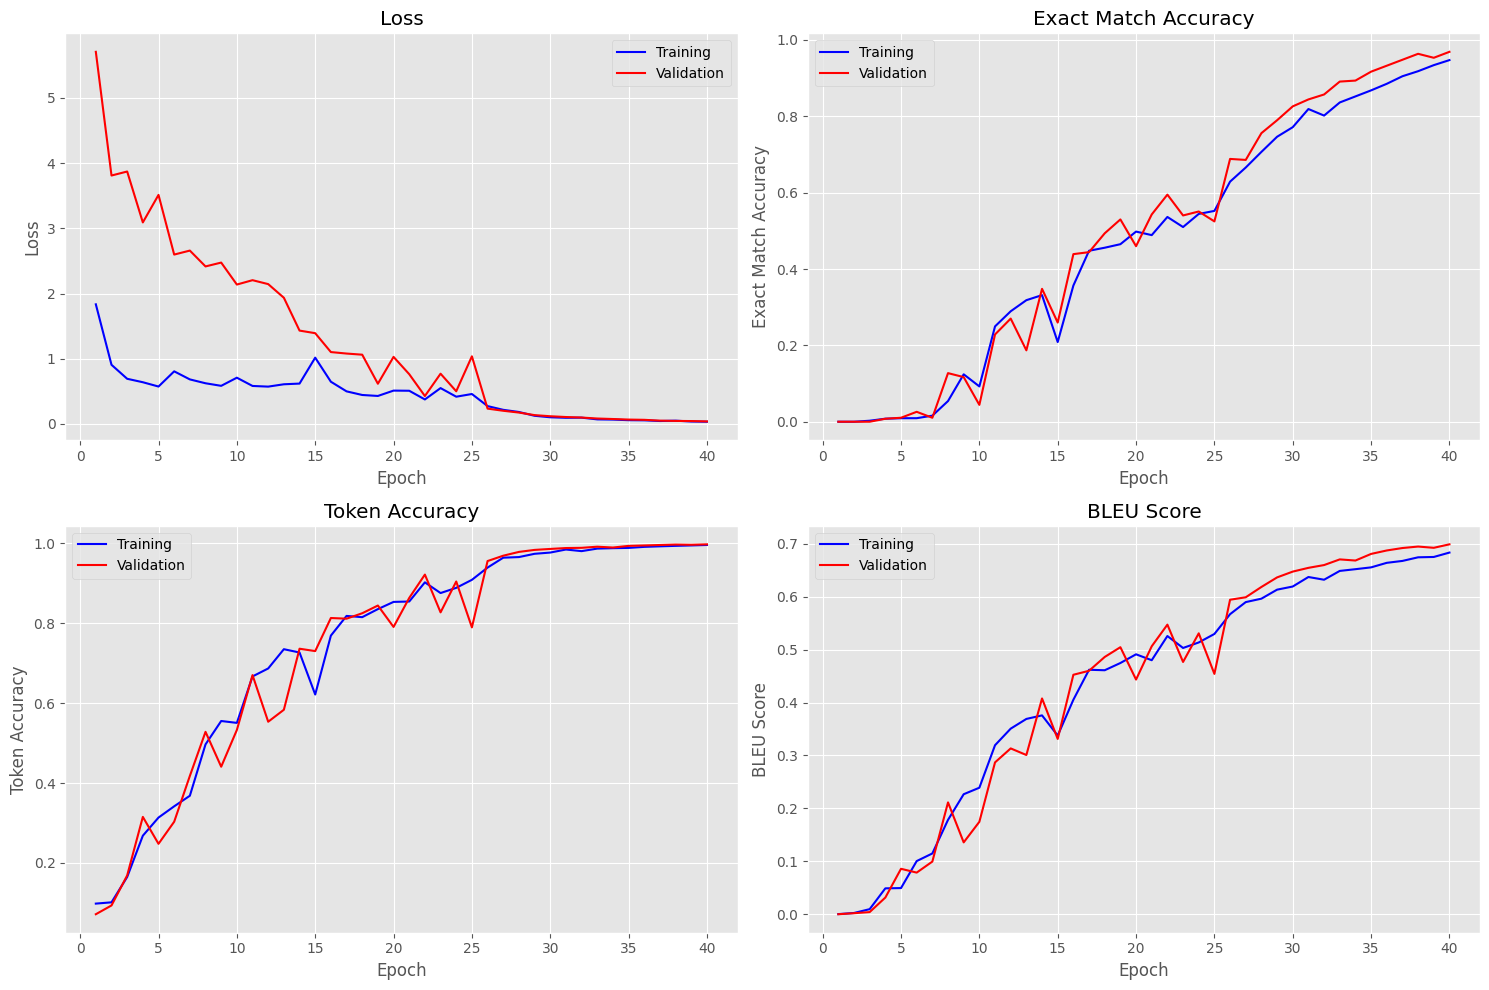

Metrics plots saved to /kaggle/working/logs/metrics_plots


In [45]:
mlflow.end_run()
# Training mode
if mode == 'train':
    if checkpoint_path:
        # Continue training from checkpoint
        print(f"Loading checkpoint from {checkpoint_path}...")
        model, tokenizer, loaded_config = load_checkpoint(checkpoint_path)
        
        # Update config with loaded config
        for key, value in vars(loaded_config).items():
            if key not in ['batch_size', 'num_epochs', 'learning_rate']:
                setattr(config, key, value)
        
        model, tokenizer, metrics_history = train_model(config)
    else:
        # Train from scratch
        model, tokenizer,metrics_history = train_model(config)

In [ ]:
def register_model_to_mlflow(model_path, model_name, tags=None):
    """Register a model in the MLflow model registry"""
    # Load the saved model
    loaded_model, tokenizer, config = load_checkpoint(model_path)
    
    # Start a new run for model registration
    with mlflow.start_run(run_name=f"register_{model_name}"):
        # Log model parameters
        log_params(config)
        
        # Log the model
        mlflow.pytorch.log_model(loaded_model, "model")
        
        # Register the model in the model registry
        registered_model = mlflow.register_model(
            f"runs:/{mlflow.active_run().info.run_id}/model",
            model_name
        )
        
        # Add tags if provided
        if tags:
            client = MlflowClient()
            for key, value in tags.items():
                client.set_model_version_tag(
                    name=model_name,
                    version=registered_model.version,
                    key=key,
                    value=value
                )
        
        print(f"Model registered with name: {model_name}, version: {registered_model.version}")
        
        # Log additional artifacts
        with tempfile.NamedTemporaryFile(suffix='.pkl', delete=False) as f:
            torch.save({'tokenizer': tokenizer, 'config': config}, f.name)
            mlflow.log_artifact(f.name, "tokenizer_config")
            os.unlink(f.name)
    
    return registered_model

In [ ]:
def load_model_from_registry(model_name, version=None, stage=None):
    """Load a model from the MLflow model registry"""
    client = MlflowClient()
    
    # Get the model version URI
    if version is not None:
        model_uri = f"models:/{model_name}/{version}"
    elif stage is not None:
        model_uri = f"models:/{model_name}/{stage}"
    else:
        model_uri = f"models:/{model_name}/latest"
    
    # Load the PyTorch model
    loaded_model = mlflow.pytorch.load_model(model_uri)
    
    # Get the run ID for this model version
    if version is not None:
        model_version = client.get_model_version(model_name, version)
    else:
        # Get latest version
        versions = client.search_model_versions(f"name='{model_name}'")
        latest_version = max(versions, key=lambda x: int(x.version))
        model_version = latest_version
    
    run_id = model_version.run_id
    
    # Download the tokenizer and config
    artifacts_path = client.download_artifacts(run_id, "tokenizer_config")
    tokenizer_config = torch.load(os.path.join(artifacts_path, os.listdir(artifacts_path)[0]))
    
    return loaded_model, tokenizer_config['tokenizer'], tokenizer_config['config']

In [ ]:
mlflow.end_run()
mode = 'test'  # Options: 'train', 'test', 'predict'
data_root = '/kaggle/input/crohme-data-basic-final/filtered_basic_arithmetic'
checkpoint_path = "checkpoints/best_model.pth"
# Testing mode
if mode == 'test':
    if not checkpoint_path:
        print("Error: Checkpoint path is required for testing")
    else:
        # Load model from checkpoint
        model, tokenizer, loaded_config = load_checkpoint(checkpoint_path)
        
        # Update config with loaded config
        for key, value in vars(loaded_config).items():
            setattr(config, key, value)
        
        # Test model
        metrics = test_model(model, tokenizer, config)
        # Register the model in MLflow model registry
        register_model_to_mlflow(
            checkpoint_path, 
            "handwritten-math-recognition", 
            tags={
                "accuracy": f"{metrics['exact_match']:.4f}",
                "dataset": os.path.basename(config.data_root),
                "description": "Handwritten mathematical expression recognition model"
            }
        )

In [ ]:
save_dir = "/kaggle/working"
plot_metrics(metrics_history, save_dir)

In [ ]:
import sys
mode = 'predict'  # Options: 'train', 'test', 'predict'
data_root = '/kaggle/input/crohme-data'
checkpoint_path = "checkpoints/best_model.pth"
image_path = "/kaggle/input/crohme-data-basic-final/filtered_basic_arithmetic/test/images/expr_000865.png"
# Prediction mode
if mode == 'predict':
    if not checkpoint_path or not image_path:
        print("Error: Both checkpoint and image paths are required for prediction")
    else:
        # Load model from checkpoint
        #model, tokenizer, loaded_config = load_checkpoint(checkpoint_path)

        # Try to load from model registry
        try:
            model, tokenizer, loaded_config = load_model_from_registry("handwritten-math-recognition")
            print(f"Loaded model handwritten-math-recognition from MLflow model registry")
        except Exception as e:
            print(f"Error loading model from registry: {e}")
            sys.exit(1)
        
        # Update config with loaded config
        for key, value in vars(loaded_config).items():
            setattr(config, key, value)
        filename = os.path.basename(image_path)
        match = re.search(r'expr_(\d+)\.png', filename)
        id = match.group(1)
        image_dir = os.path.dirname(image_path)
        parent_dir = os.path.dirname(image_dir)
        label_path = os.path.join(parent_dir, 'labels', f'expr_{id}.txt')
        f = open(label_path,'r')
        true_latex = f.read()
        
        # Predict on image
        latex = predict_image(model, tokenizer, image_path, config)
        print(f"Predicted LaTeX: {latex}")
        print(f"True LaTeX: {true_latex}")
        
        # Optional: Display the image
        from PIL import Image
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(10, 4))
        plt.imshow(Image.open(image_path).convert('L'), cmap='gray')
        #plt.title(f"Prediction: {latex}")
        plt.axis('off')
        plt.show()

In [ ]:
import mlflow
from mlflow.tracking import MlflowClient

client = MlflowClient()

# For older MLflow versions
try:
    # Try to get registered models using search_registered_models (newer versions)
    registered_models = client.search_registered_models()
    for rm in registered_models:
        print(f"Model: {rm.name}")
        
        # List versions for this model
        versions = client.get_latest_versions(rm.name)
        for v in versions:
            print(f"  Version: {v.version}, Stage: {v.current_stage}, Run ID: {v.run_id}")
except AttributeError:
    # Fallback for very old versions - list all runs and extract model info
    print("Using fallback method to list models:")
    runs = mlflow.search_runs()
    if not runs.empty:
        print(f"Found {len(runs)} runs")
        for _, run in runs.iterrows():
            print(f"Run ID: {run.run_id}, Experiment ID: {run.experiment_id}")
            # Try to get artifacts list
            try:
                artifacts = client.list_artifacts(run.run_id)
                for artifact in artifacts:
                    if artifact.path.startswith("model"):
                        print(f"  Model artifact: {artifact.path}")
            except:
                print("  Could not list artifacts for this run")
    else:
        print("No runs found")